In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import sklearn 
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.column import encode_categorical
from sksurv.ensemble import RandomSurvivalForest

In [20]:
from preprocessing import readcounts_processing_pipeline, pheno_processing_pipeline, prepare_train_test, remove_unique_columns
from HosmerLemeshow import HosmerLemeshow, reformat_inputs
pheno_df_train = pd.read_csv('./train/pheno_training.csv')
pheno_df_train = pheno_processing_pipeline(pheno_df_train)

pheno_df_test = pd.read_csv('./test/pheno_test.csv')
pheno_df_test = pheno_processing_pipeline(pheno_df_test)

readcounts_df_train = pd.read_csv('./train/readcounts_training.csv')
readcounts_df_train = readcounts_processing_pipeline(readcounts_df_train)

readcounts_df_test = pd.read_csv('./test/readcounts_test.csv')
readcounts_df_test = readcounts_processing_pipeline(readcounts_df_test)


## Start with a baseline model 
     

In [60]:
pheno_df = pd.concat([pheno_df_train, pheno_df_test])
pheno_df = pheno_df.loc[pheno_df.Event_time > 0]
t0 = pheno_df['Event_time'].min()
tf = pheno_df['Event_time'].max()

times = np.linspace(t0, tf, 15)
times = times[1:-1]

In [61]:
times

array([ 1.25614286,  2.39028571,  3.52442857,  4.65857143,  5.79271429,
        6.92685714,  8.061     ,  9.19514286, 10.32928571, 11.46342857,
       12.59757143, 13.73171429, 14.86585714])

In [62]:
def test_base_model(base_model, X_train, X_test, y_train, y_test, times):
    preds_train = base_model.predict(X_train)
    preds_test = base_model.predict(X_test)
    
    #Harrel's concordance index C is defined as the proportion of observations that the model can order correctly in terms of survival times. 
    concordance_index_censored_train = concordance_index_censored(y_train["Event"], y_train["Event_time"], preds_train)

    concordance_index_censored_test = concordance_index_censored(y_test["Event"], y_test["Event_time"], preds_test)
    
    #data_train = reformat_inputs(X_train, preds_train)
    #HL_test = HosmerLemeshow(data_train, preds_train, Q=10)
    #concordance_index_ipcw_train = concordance_index_ipcw(y_train, y_train, preds_train)
    #cumulative_dynamic_auc_train = cumulative_dynamic_auc(y_train, y_train, preds_train, times)
    
     
    survs = base_model.predict_survival_function(X_train)
    
    preds = np.asarray([[fn(t) for t in times] for fn in survs])
    #integrated_brier_score_train = integrated_brier_score(y_train, y_train, preds, times)
    integrated_brier_score_test = integrated_brier_score(y_train, y_test, preds, times)

     
    cumulative_dynamic_auc_test = [0] #cumulative_dynamic_auc(y_train, y_test, preds_test, times)
    concordance_index_ipcw_test = [0]#concordance_index_ipcw(y_train, y_test, preds_test)
     

    concordance_index_ipcw_train = concordance_index_ipcw_test #############################
    cumulative_dynamic_auc_train = cumulative_dynamic_auc_test #######################################################################
    integrated_brier_score_train = integrated_brier_score_test ######################################################################
    
    result = {'Harrell_C_train':  concordance_index_censored_train[0], 'Harrell_C_test' : concordance_index_censored_test[0]}
    
    result_test = {'Harrell C': concordance_index_censored_test[0],
              'Concordance index IPCW': concordance_index_ipcw_test[0],
              #'Cumulative Dynamic AUC' : [cumulative_dynamic_auc_train, cumulative_dynamic_auc_test], 
              'Integrated Brier Score': integrated_brier_score_test}
 
    #result = {'Harrell C': [concordance_index_censored_train[0], concordance_index_censored_test[0]], 'Concordance index IPCW': [concordance_index_ipcw_train[0], concordance_index_ipcw_test[0]],
              #'Cumulative Dynamic AUC' : [cumulative_dynamic_auc_train, cumulative_dynamic_auc_test], 
            #  'Integrated Brier Score': [integrated_brier_score_train, integrated_brier_score_test]}
    
    return pd.DataFrame(result_test)

In [ ]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

### Cox model with only Age + Sex covariates

In [63]:
base_model = CoxPHSurvivalAnalysis(alpha=0, ties='breslow', n_iter=100, tol=1e-09, verbose=0)
  
covariates = ['Sex=1', 'Age']

X_train, X_test, y_train, y_test = prepare_train_test(pheno_df_train, pheno_df_test, covariates)

base_model.fit(X_train, y_train)

test_base_model(base_model, X_train, X_test, y_train, y_test, times)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert yo

,Harrell C,Concordance index IPCW,Cumulative Dynamic AUC,Integrated Brier Score
0,0.712404,0,[0],0.01323
1,0.720504,0,[0],0.01323


Plot the estimated survival function

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


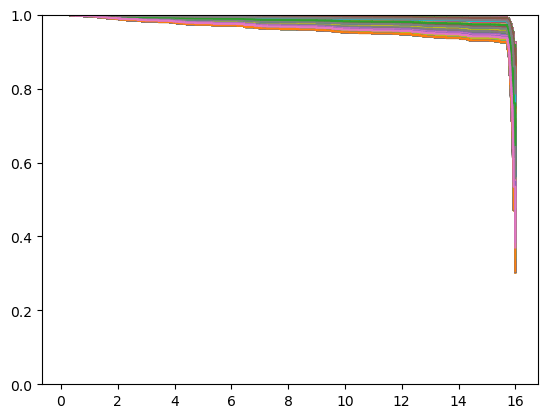

In [5]:
S = base_model.predict_survival_function(X_train)

for fn in S:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()

### Cox model with all clinical covariates

In [68]:
base_model = CoxPHSurvivalAnalysis(alpha=0, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = ['Age', 'BodyMassIndex', 'Smoking=1', 'BPTreatment=1',
       'PrevalentDiabetes=1', 'PrevalentCHD=1', 'SystolicBP', 'NonHDLcholesterol', 'Sex=1']

X_train, X_test, y_train, y_test = prepare_train_test(pheno_df_train, pheno_df_test, covariates)

base_model.fit(X_train, y_train)

test_base_model(base_model, X_train, X_test, y_train, y_test, times)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert yo

,Harrell C,Concordance index IPCW,Cumulative Dynamic AUC,Integrated Brier Score
0,0.715808,0,[0],0.013283
1,0.708009,0,[0],0.013283


### Random forest survival model with all clinical covariates + microbiome data

In [7]:
readcounts_df_train, readcounts_df_test = remove_unique_columns(readcounts_df_train, readcounts_df_test)

In [69]:
df_train = pheno_df_train.join(readcounts_df_train)
df_test = pheno_df_test.join(readcounts_df_test)
base_model = RandomSurvivalForest(n_estimators=100, max_depth=None, min_samples_split=6, min_samples_leaf=3)  

covariates = df_train.columns                   
X_train, X_test, y_train, y_test = prepare_train_test(df_train, df_test, covariates)

base_model.fit(X_train, y_train)

test_base_model(base_model, X_train, X_test, y_train, y_test, times)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


,Harrell C,Concordance index IPCW,Cumulative Dynamic AUC,Integrated Brier Score
0,0.995276,0,[0],0.011409
1,0.970867,0,[0],0.011409


In [9]:
preds_train = base_model.predict(X_train)
data = reformat_inputs(X_train, preds_train)
HL_test = HosmerLemeshow(data, preds_train, Q=10)

AttributeError: 'numpy.ndarray' object has no attribute 'p1'

correct adjustment for the age at
entry is crucial in reducing bias of the estimated
coefficients.Using “age-as-the-time scale”
instead of “time-on-follow-up”
Reason: account for left trun-
cation of age
Cox PH model that adjusts for
age truncation:

In [11]:
import rpy2.robjects as ro
path='./src/hosmerTest.R'

def function1(input,output):
    r=ro.r
    r.source(path+"rtest.R")
    p=r.rtest(input,output)
    return p

ModuleNotFoundError: No module named 'rpy2'